# Stage 1

## FsrGAN size_factor=2

batch_size = 64, epochs 40.

### Scores

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
import numpy as np
g1_rundir = 'best_runs/stage_1_size_2'
scores = torch.load(f'{g1_rundir}/run_info.pt')['scores']
hyperpar = torch.load(f'{g1_rundir}/run_info.pt')['hyperparams']

/tmp/ipykernel_174404/4266787676.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores = torch.load(f'{g1_rundir}/run_info.pt')['scores']
/tmp/ipykernel_174404/42667876

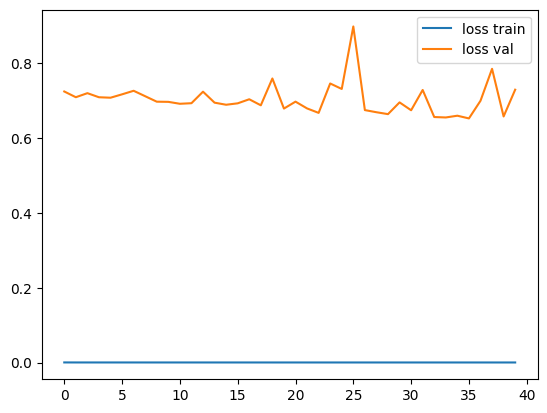

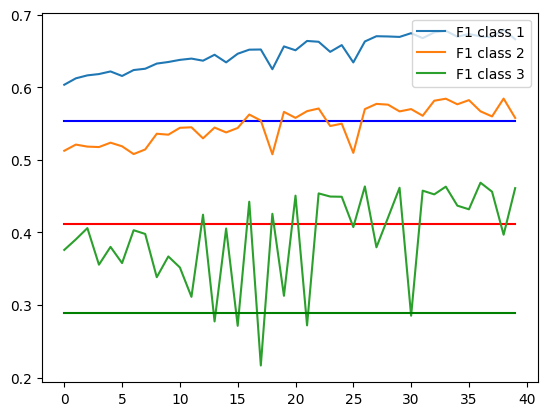

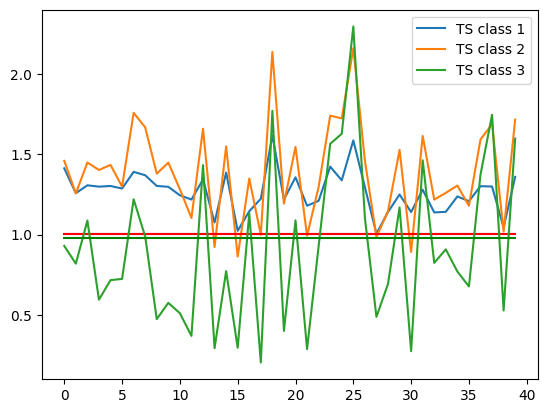

In [24]:
import matplotlib.pyplot as plt

def plot_scores( scores):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses1'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1_1']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    sc = scores['val_bias1']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='TS class 1')
    plt.plot([scores['bias_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='TS class 2')
    plt.plot([scores['bias_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='TS class 3')
    plt.plot([scores['bias_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    
plot_scores(scores)

### Inference

In [30]:
from models.FsrGAN import FirstStage

thresholds = hyperpar['thresholds']
input_len = 12
time_horizon = 6
stride = 12
batch_size = 16
model1_g = FirstStage(input_len, time_horizon, size_factor=2)

#### Dataset

In [26]:
from meteonet.loader import MeteonetDatasetChunked
from meteonet.samplers import meteonet_sequential_sampler
from torch.utils.data import DataLoader

test_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "test",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)
val_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "val",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)
train_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "train",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)

test_sampler = meteonet_sequential_sampler(test_ds)
test_loader = DataLoader(
    test_ds,
    batch_size,
    sampler=test_sampler,
    num_workers=4,
    pin_memory=True,
)

Loading cached moments for test data from ./data-chunked/moments_test.npz
Loading cached moments for val data from ./data-chunked/moments_val.npz
Loading cached moments for train data from ./data-chunked/moments_train.npz


#### Load Model

In [42]:
model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_last_epoch.pt'))
# model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_epoch_39.pt'))
# model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_epoch_37.pt'))
# model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_epoch_35.pt'))

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def __call__(self, x):
        return train_ds.denormalize_rainmap(self.model(x)).squeeze(1)
    def to(self, device):
        self.model.to(device)
    def eval(self):
        self.model.eval()
        return self
model1_g_wrapp = ModelWrapper(model1_g)

/tmp/ipykernel_174404/3208809961.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_last_epoch.pt'))


#### Prediction examples - test

In [43]:
from meteonet.plots import plot_meteonet_rainmaps
from tests.pred_example.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

test_date = 2018, 2, 11, 14, 5
# plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)

In [44]:
import matplotlib.pyplot as plt
from matplotlib import colors
from meteonet.utilities import get_item_by_date, load_map, split_date, map_to_classes
import torch

def plot_inference(ds, date, model, thresholds, lon, lat, zone, title):
    """ plot an inference for a given date and compare to truth """
    idx = ds.get_item_idx_by_date(date)    
    if idx == None: return None

    item = ds[idx]
    model.eval()
    with torch.no_grad():
        preds = model(item['inputs'].unsqueeze(0)).squeeze(0)
    y, M, d, h, m = split_date(item['target_name'])

    fig, axes = plt.subplots(2, preds.shape[0], figsize=(20, 9))
    fig.suptitle(title) 

    cmap = colors.ListedColormap(['white', 'mediumblue', 'skyblue', 'cyan'])

    for i in range(preds.shape[0]):
        pred = 1 * (preds[i] > thresholds[0]) + (preds[i] > thresholds[1]) + (preds[i] > thresholds[2])
        pred = pred.squeeze()
        pred[0, 0] = 3
        target = item['target'][i]
        true = 1 * (target > thresholds[0]) + (target > thresholds[1]) + (target > thresholds[2])

        axes[0, i].set_title(f'Time step {i+1} Truth')
        axes[0, i].set_xlabel('longitude')
        axes[0, i].pcolormesh(lon, lat, true, cmap=cmap)
        
        axes[1, i].set_title(f'Time step {i+1} Prediction')
        axes[1, i].set_ylabel('latitude')
        axes[1, i].set_xlabel('longitude')
        axes[1, i].pcolormesh(lon, lat, pred, cmap=cmap)


    fig.text(0.3, -0.05, 'thresholds: mediumblue >= 0.8, skyblue >= 8.3, cyan >=20.3')
    plt.show()

In [45]:
thresholds = hyperpar['thresholds']

plot_inference( test_ds, test_date, model1_g_wrapp, thresholds, lon, lat, zone, 'model Dom with windmaps')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [35]:
def plot_CT( dataset, date, model, thresholds, c):
    """
        for a given date in a dataset and a class c, plot prediction and ground-truth, true positives, false positives 
        and false negative
    """
    idx = dataset.get_item_idx_by_date(date)    
    if idx == None: return None

    item = dataset[idx]
    print(item['inputs'].unsqueeze(0).shape)
    model.eval()
    with torch.no_grad():
        y_hat = model(item['inputs'].unsqueeze(0))

    true = map_to_classes(item['target'].unsqueeze(0), thresholds)
    pred = (torch.sigmoid(y_hat) > 0.5)
    
    plt.figure(figsize=(10,10))
    plt.suptitle( f'class {c}')
    plt.subplot(2,2,1)
    plt.imshow(pred[0,c]*1 + 2*true[0,c])
    plt.subplot(2,2,2)
    TP = pred[0,c]*true[0,c]
    plt.title(f'TP: {int(TP.sum())}')
    plt.imshow(TP)
    plt.subplot(2,2,3)
    FP = pred[0,c]*(true[0,c]==False)
    plt.title(f'FP: {int(FP.sum())}')
    plt.imshow(FP)
    plt.subplot(2,2,4)
    FN = (pred[0,c] == False)*(true[0,c])
    plt.title(f'FN: {int((FN).sum())}')
    plt.imshow(FN)
    plt.show()

In [36]:
# plot_CT( test_ds, test_date, model1_g_wrapp, thresholds, 0)

#### Test Scores

In [46]:
from tqdm import tqdm
from meteonet.utilities import calculate_CT, calculate_BS, map_to_classes
import pandas as pd

device = torch.device('cuda')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y = data['inputs'], train_ds.denormalize_rainmap(data['target'][:,-1])
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)[:,-1].squeeze(1)
        # print(y_hat.shape, y.shape)
        # print(y_hat.shape, y.shape)
        TPFPFN += calculate_CT(map_to_classes(y_hat, thresholds), map_to_classes(y, thresholds))
        # print(TPFPFN)
    return TPFPFN.cpu()

In [47]:
stats = eval_test( test_loader, model1_g_wrapp, device)

  0%|          | 0/241 [00:00<?, ?it/s]

100%|██████████| 241/241 [02:42<00:00,  1.49it/s]


In [48]:
pd.DataFrame( stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,2981672,1918755,830513
TN,57844120,59041432,59348695
FP,1591391,394079,86816
FN,743137,1806054,2894296


In [49]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
scores_BS = ['Precision', 'Recall',              'F1','TS',    'BIAS','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_BS( stats, scores_BS), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.652008,0.829612,0.905360
Recall/Success Ratio,0.800490,0.515128,0.222968
F1,0.718659,0.635597,0.357815
TS/CSI,0.560865,0.465843,0.217889
Bias,1.227731,0.620927,0.246275
HSS,0.699100,0.618354,0.342490
FAR,0.026775,0.006630,0.001461
Accuracy,0.963038,0.965166,0.952801
ETS,0.537397,0.447549,0.206629
ORSS,0.986380,0.987513,0.989856


# Stage 2 (with wind)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
# g1_rundir = 'best_runs/stage_1_size_2'
rundir_s2 = 'runs/s2/2025-02-01_17-27-40'

scores_s2 = torch.load(f'{rundir_s2}/run_info.pt')['scores']
hyperpar_s2 = torch.load(f'{rundir_s2}/run_info.pt')['hyperparams']

/tmp/ipykernel_79444/3500359409.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores_s2 = torch.load(f'{rundir_s2}/run_info.pt')['scores']
/tmp/ipykernel_79444/3500359

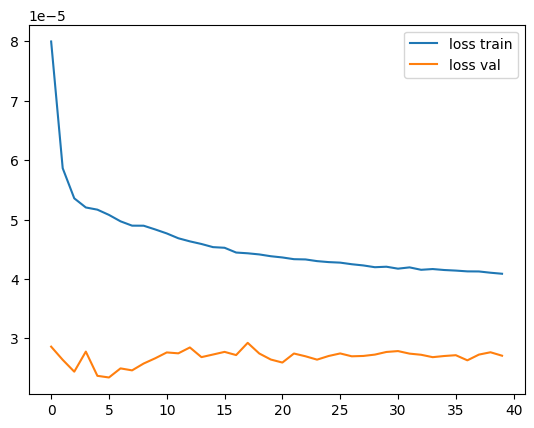

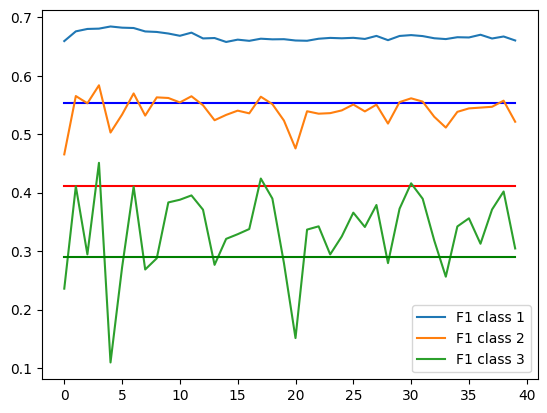

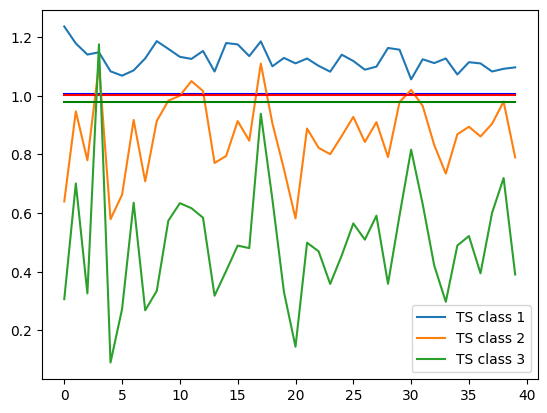

In [5]:
import matplotlib.pyplot as plt
def plot_scores( scores):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    sc = scores['val_bias']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='TS class 1')
    plt.plot([scores['bias_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='TS class 2')
    plt.plot([scores['bias_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='TS class 3')
    plt.plot([scores['bias_pers'][2]]*l,'g')
    plt.legend()
    plt.show()

plot_scores(scores_s2)

## load model

In [6]:
from models.FsrGAN import FsrSecondStageGenerator

thresholds = hyperpar_s2['thresholds']
input_len = 12
time_horizon = 6
stride = 12
batch_size = 16
model_g_s2 = FsrSecondStageGenerator(input_len, time_horizon, size_factor=1)

In [7]:
model_g_s2.load_state_dict(torch.load(f'{rundir_s2}/model_s2_last_epoch.pt'))

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def __call__(self, x, x_s1):
        return train_ds.denormalize_rainmap(self.model(x, x_s1)).squeeze(1)
    def to(self, device):
        self.model.to(device)
        return self
    def eval(self):
        self.model.eval()
        return self
model_s2_g_wrapp = ModelWrapper(model_g_s2)

/tmp/ipykernel_79444/4144491516.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_g_s2.load_state_dict(torch.load(f'{rundir_s2}/model_s2_last_epoch.pt'))


## Dataset

In [8]:
from meteonet.loader import MeteonetDatasetChunked, DatsetWrapperFsrSecondStage
from meteonet.samplers import meteonet_sequential_sampler
from torch.utils.data import DataLoader
import os

test_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "test",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)
test_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "test"), test_ds
)
val_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "val",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)
val_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "val"), val_ds
)
train_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "train",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=True,
    normalize_target=False
)
train_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "train"), train_ds
)

test_sampler = meteonet_sequential_sampler(test_ds_wrapp)
test_loader = DataLoader(
    test_ds_wrapp,
    batch_size,
    sampler=test_sampler,
    num_workers=4,
    pin_memory=True,
)


Loading cached moments for test data from ./data-chunked/moments_test.npz
Loading cached moments for val data from ./data-chunked/moments_val.npz
Loading cached moments for train data from ./data-chunked/moments_train.npz


## Examples

In [9]:
from meteonet.plots import plot_meteonet_rainmaps
from tests.pred_example.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

test_date = 2018, 2, 11, 14, 5
# plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)


import matplotlib.pyplot as plt
from matplotlib import colors
from meteonet.utilities import get_item_by_date, load_map, split_date, map_to_classes
import torch

def plot_inference(ds, date, model, thresholds, lon, lat, zone, title):
    """ plot an inference for a given date and compare to truth """
    idx = ds.dataset.get_item_idx_by_date(date)    
    if idx == None: return None

    item = ds[idx]
    model.eval()
    with torch.no_grad():
        preds = model(item['inputs'].unsqueeze(0), item['first_stage_pred'].unsqueeze(0)).squeeze(0)
    y, M, d, h, m = split_date(item['target_name'])

    fig, axes = plt.subplots(3, preds.shape[0], figsize=(20, 10))
    fig.suptitle(title) 

    cmap = colors.ListedColormap(['white', 'mediumblue', 'skyblue', 'cyan'])

    for i in range(preds.shape[0]):
        pred = 1 * (preds[i] > thresholds[0]) + (preds[i] > thresholds[1]) + (preds[i] > thresholds[2])
        pred = pred.squeeze()
        pred[0, 0] = 3
        target = item['target'][i]
        true = 1 * (target > thresholds[0]) + (target > thresholds[1]) + (target > thresholds[2])

        stage_1 = ds.dataset.denormalize_rainmap(item['first_stage_pred'][i])
        stage_1 = 1 * (stage_1 > thresholds[0]) + (stage_1 > thresholds[1]) + (stage_1 > thresholds[2])
        stage_1 = stage_1.squeeze()

        axes[0, i].set_title(f'Time step {i+1} Truth')
        axes[0, i].set_xlabel('longitude')
        axes[0, i].pcolormesh(lon, lat, true, cmap=cmap)
        
        axes[1, i].set_title(f'Time step {i+1} Prediction S2')
        axes[1, i].set_ylabel('latitude')
        axes[1, i].set_xlabel('longitude')
        axes[1, i].pcolormesh(lon, lat, pred, cmap=cmap)

        axes[2, i].set_title(f'Time step {i+1} Prediction S1')
        axes[2, i].set_ylabel('latitude')
        axes[2, i].set_xlabel('longitude')
        axes[2, i].pcolormesh(lon, lat, stage_1, cmap=cmap)


    fig.text(0.3, -0.05, 'thresholds: mediumblue >= 0.8, skyblue >= 8.3, cyan >=20.3')
    plt.show()

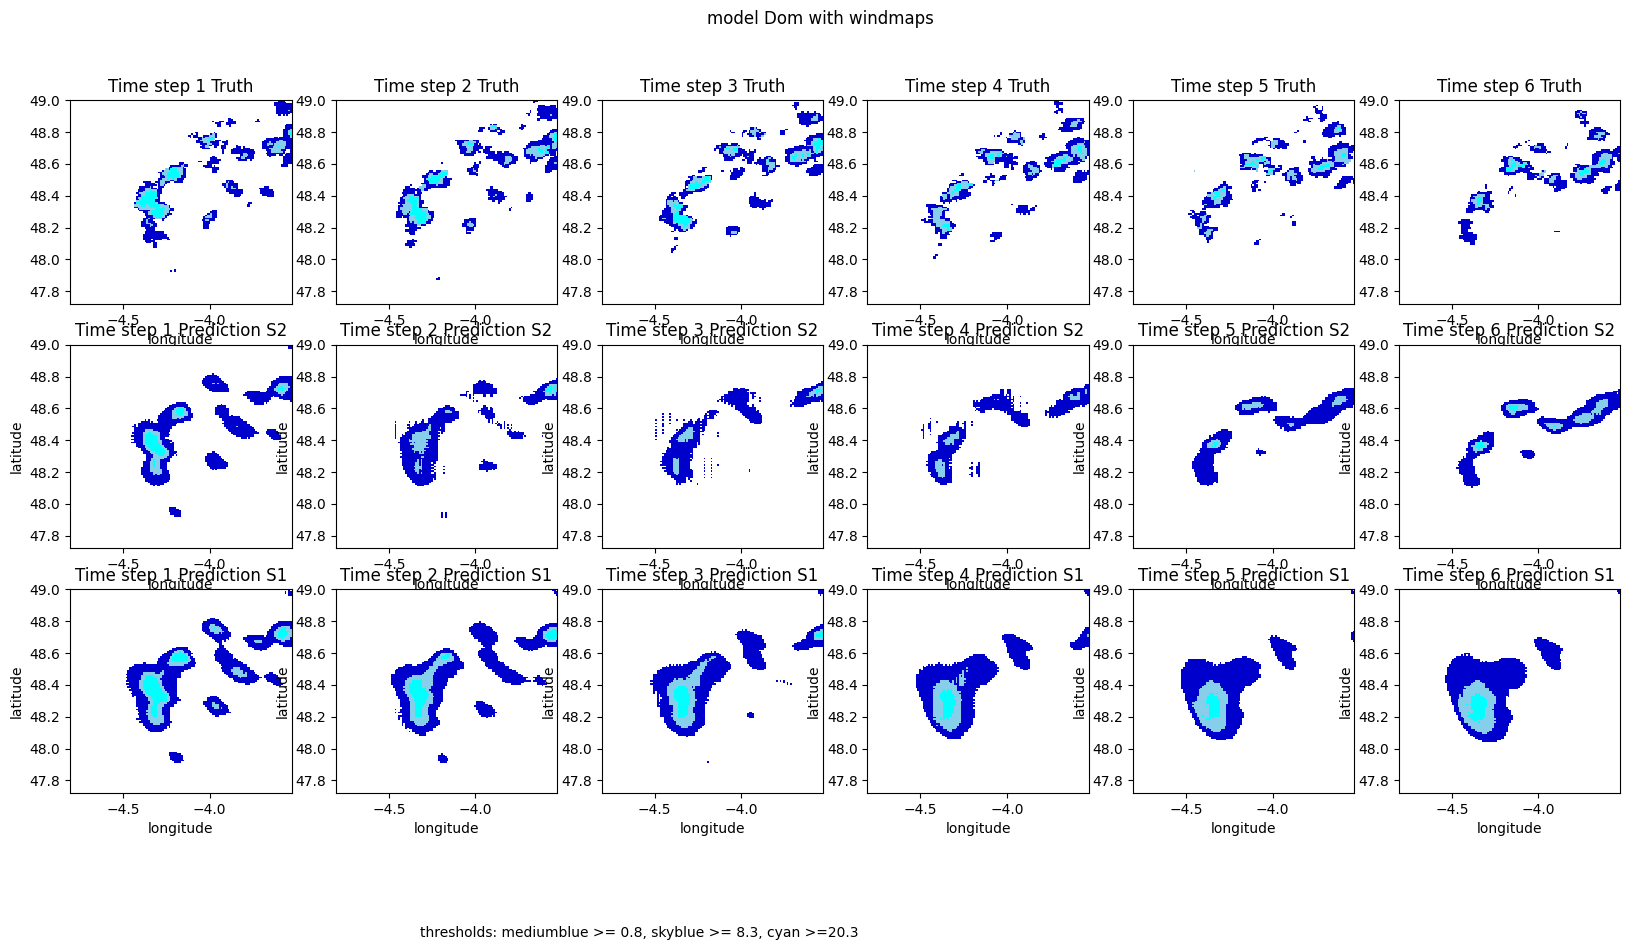

In [25]:
thresholds = hyperpar_s2['thresholds']

train_date = 2017,4,1,12,0 # dans train_ds
train_date = 2017,9,1,12,0 # dans train_ds
train_date = 2017,12,1,12,0 # dans train_ds
plot_inference( train_ds_wrapp, train_date, model_s2_g_wrapp.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')

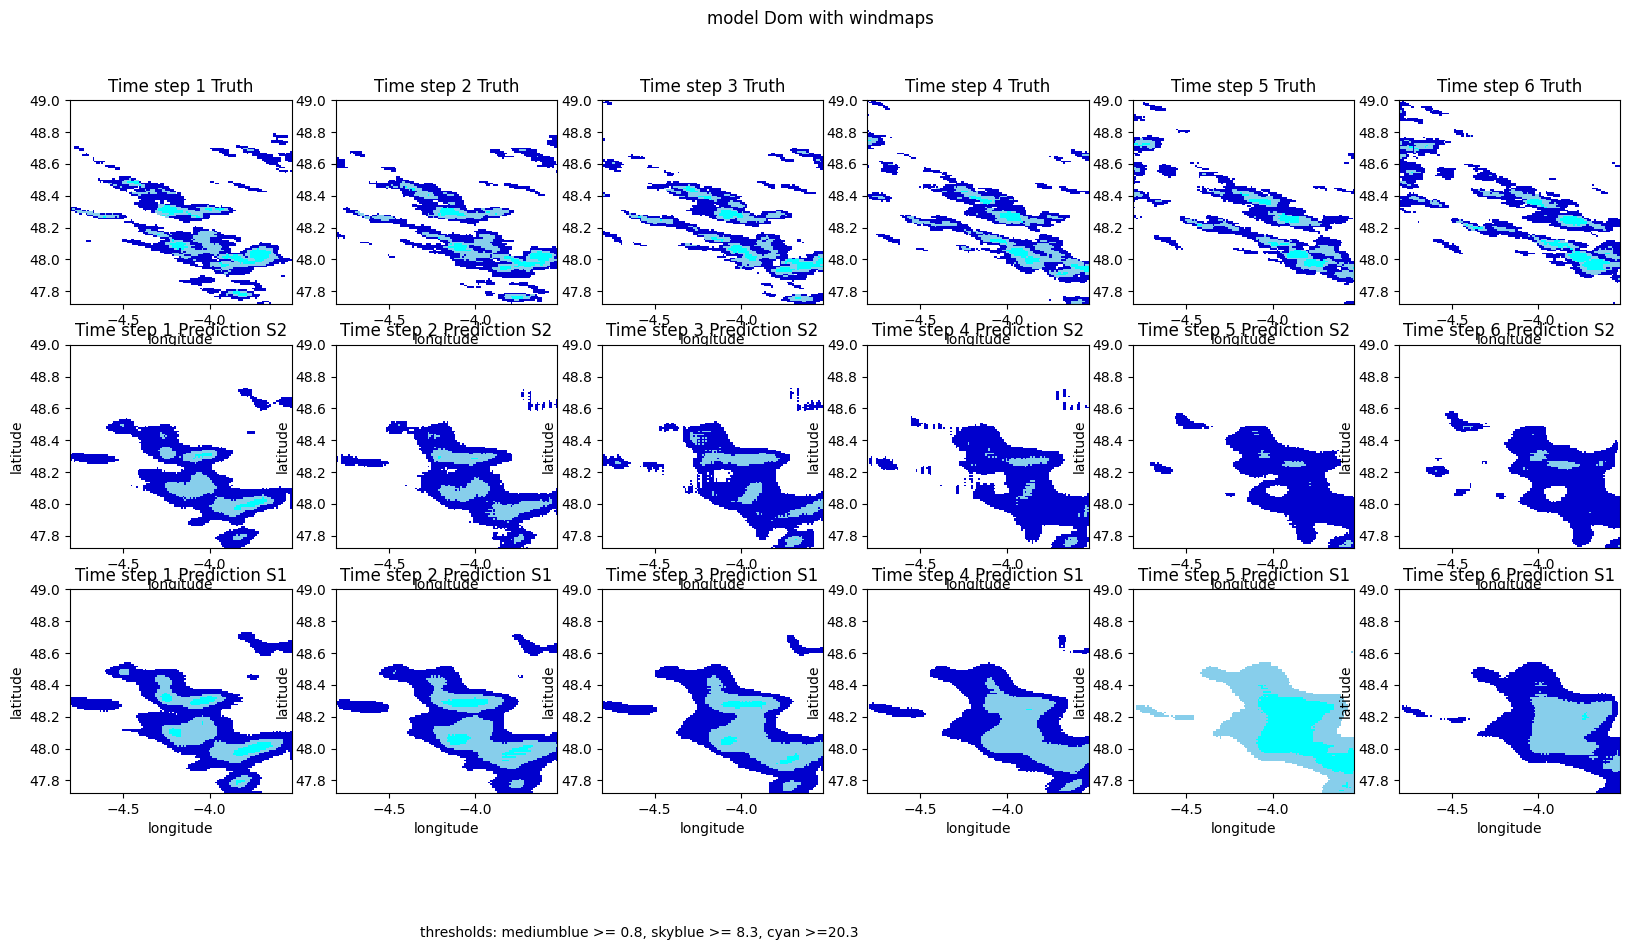

In [12]:
val_date = 2018,3,12,3,5 # dans val_ds
plot_inference( val_ds_wrapp, val_date, model_s2_g_wrapp.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')

## Scores

In [13]:
from tqdm import tqdm
from meteonet.utilities import calculate_CT, calculate_BS, map_to_classes
import pandas as pd

device = torch.device('cuda')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y,x_s1 = data['inputs'], train_ds.denormalize_rainmap(data['target'][:,-1]), data['first_stage_pred']
        x, y, x_s1 = x.to(device), y.to(device), x_s1.to(device)
        with torch.no_grad():
            y_hat = model(x, x_s1)[:,-1].squeeze(1)
        # print(y_hat.shape, y.shape)
        # print(y_hat.shape, y.shape)
        TPFPFN += calculate_CT(map_to_classes(y_hat, thresholds), map_to_classes(y, thresholds))
        # print(TPFPFN)
    return TPFPFN.cpu()

In [14]:
stats = eval_test( test_loader, model_s2_g_wrapp, device)


100%|██████████| 241/241 [00:19<00:00, 12.06it/s]


In [15]:
pd.DataFrame( stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,2628327,854688,143118
TN,58359948,59347982,59426419
FP,1075563,87529,9092
FN,1096482,2870121,3581691


In [16]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
scores_BS = ['Precision', 'Recall',              'F1','TS',    'BIAS','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_BS( stats, scores_BS), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.709613,0.907103,0.940267
Recall/Success Ratio,0.705627,0.229458,0.038423
F1,0.707614,0.366267,0.073829
TS/CSI,0.547526,0.224190,0.038329
Bias,0.994384,0.252957,0.040864
HSS,0.689346,0.350809,0.069520
FAR,0.018096,0.001473,0.000153
Accuracy,0.965611,0.953172,0.943148
ETS,0.525955,0.212715,0.036012
ORSS,0.984740,0.990144,0.992371


# Stage 1 (Without wind)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
g1_rundir = 'best_runs/stage_1_size_1_no_wind'
scores = torch.load(f'{g1_rundir}/run_info.pt')['scores']
hyperpar = torch.load(f'{g1_rundir}/run_info.pt')['hyperparams']

/tmp/ipykernel_5847/1782721846.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores = torch.load(f'{g1_rundir}/run_info.pt')['scores']


FileNotFoundError: [Errno 2] No such file or directory: 'best_runs/stage_1_size_1_no_wind/run_info.pt'

In [7]:
from models.FsrGAN_no_wind import FirstStageRadarOnly

thresholds = [0.8333333333333334, 8.333333333333334, 20.833333333333332]
input_len = 12
time_horizon = 6
stride = 12
batch_size = 16
model1_g = FirstStageRadarOnly(input_len, time_horizon, size_factor=1)

In [8]:
from meteonet.loader import MeteonetDatasetChunked
from meteonet.samplers import meteonet_sequential_sampler
from torch.utils.data import DataLoader

test_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "test",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False
)
val_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "val",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False
)
train_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "train",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False
)

test_sampler = meteonet_sequential_sampler(test_ds)
test_loader = DataLoader(
    test_ds,
    batch_size,
    sampler=test_sampler,
    num_workers=4,
    pin_memory=True,
)

Loading cached moments for test data from ./data-chunked/moments_test.npz
Loading cached moments for val data from ./data-chunked/moments_val.npz
Loading cached moments for train data from ./data-chunked/moments_train.npz


In [9]:
model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_epoch_8.pt'))

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def __call__(self, x):
        return train_ds.denormalize_rainmap(self.model(x)).squeeze(1)
    def to(self, device):
        self.model.to(device)
    def eval(self):
        self.model.eval()
        return self
model1_g_wrapp = ModelWrapper(model1_g)

/tmp/ipykernel_5847/1062280914.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1_g.load_state_dict(torch.load(f'{g1_rundir}/model_s1_epoch_8.pt'))


In [10]:
from meteonet.plots import plot_meteonet_rainmaps
from tests.pred_example.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

test_date = 2018, 2, 11, 14, 5
# plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
from meteonet.utilities import get_item_by_date, load_map, split_date, map_to_classes
import torch

def plot_inference(ds, date, model, thresholds, lon, lat, zone, title):
    """ plot an inference for a given date and compare to truth """
    idx = ds.get_item_idx_by_date(date)    
    if idx == None: return None

    item = ds[idx]
    model.eval()
    with torch.no_grad():
        preds = model(item['inputs'].unsqueeze(0)).squeeze(0)
    y, M, d, h, m = split_date(item['target_name'])

    fig, axes = plt.subplots(2, preds.shape[0], figsize=(20, 9))
    fig.suptitle(title) 

    cmap = colors.ListedColormap(['white', 'mediumblue', 'skyblue', 'cyan'])

    for i in range(preds.shape[0]):
        pred = 1 * (preds[i] > thresholds[0]) + (preds[i] > thresholds[1]) + (preds[i] > thresholds[2])
        pred = pred.squeeze()
        pred[0, 0] = 3
        target = item['target'][i]
        true = 1 * (target > thresholds[0]) + (target > thresholds[1]) + (target > thresholds[2])

        axes[0, i].set_title(f'Time step {i+1} Truth')
        axes[0, i].set_xlabel('longitude')
        axes[0, i].pcolormesh(lon, lat, true, cmap=cmap)
        
        axes[1, i].set_title(f'Time step {i+1} Prediction')
        axes[1, i].set_ylabel('latitude')
        axes[1, i].set_xlabel('longitude')
        axes[1, i].pcolormesh(lon, lat, pred, cmap=cmap)


    fig.text(0.3, -0.05, 'thresholds: mediumblue >= 0.8, skyblue >= 8.3, cyan >=20.3')
    plt.show()

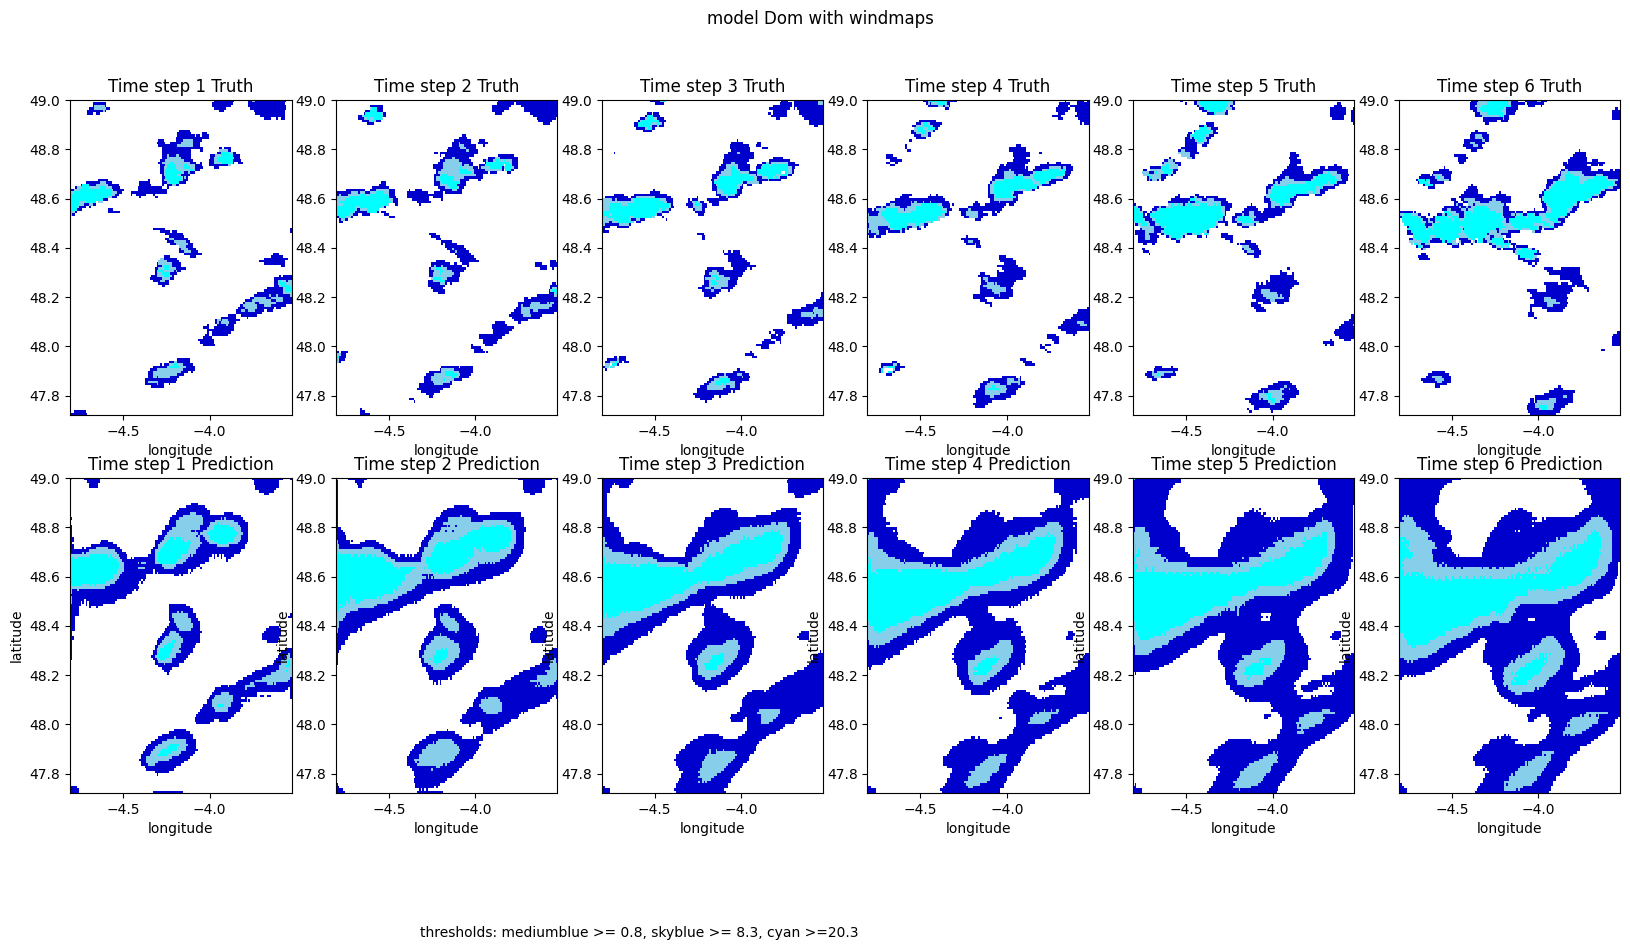

In [13]:
# thresholds = hyperpar['thresholds']

plot_inference( test_ds, test_date, model1_g_wrapp, thresholds, lon, lat, zone, 'model Dom with windmaps')

In [14]:
from tqdm import tqdm
from meteonet.utilities import calculate_CT, calculate_BS, map_to_classes
import pandas as pd

device = torch.device('cuda')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y = data['inputs'], train_ds.denormalize_rainmap(data['target'][:,-1])
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)[:,-1].squeeze(1)
        # print(y_hat.shape, y.shape)
        # print(y_hat.shape, y.shape)
        TPFPFN += calculate_CT(map_to_classes(y_hat, thresholds), map_to_classes(y, thresholds))
        # print(TPFPFN)
    return TPFPFN.cpu()

In [15]:
stats = eval_test( test_loader, model1_g_wrapp, device)

100%|██████████| 270/270 [01:42<00:00,  2.64it/s]


In [16]:
pd.DataFrame( stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,4053073,3353348,2095348
TN,61606464,63423937,64722306
FP,4203108,2385635,1087266
FN,752395,1452120,2710120


In [17]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
scores_BS = ['Precision', 'Recall',              'F1','TS',    'BIAS','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_BS( stats, scores_BS), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.490914,0.584310,0.658373
Recall/Success Ratio,0.843429,0.697819,0.436034
F1,0.620607,0.636040,0.524619
TS/CSI,0.449913,0.466319,0.355582
Bias,1.718081,1.194261,0.662290
HSS,0.584895,0.606923,0.497363
FAR,0.063868,0.036251,0.016521
Accuracy,0.929824,0.945652,0.946224
ETS,0.413323,0.435670,0.330993
ORSS,0.974987,0.967946,0.957469


# Stage 2 (without wind)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import numpy as np
# g1_rundir = 'best_runs/stage_1_size_2'
rundir_s2 = 'best_runs/stage_2_no_wind/'

scores_s2 = torch.load(f'{rundir_s2}/run_info.pt')['scores']
hyperpar_s2 = torch.load(f'{rundir_s2}/run_info.pt')['hyperparams']

/tmp/ipykernel_177172/2564332583.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores_s2 = torch.load(f'{rundir_s2}/run_info.pt')['scores']
/tmp/ipykernel_177172/25643

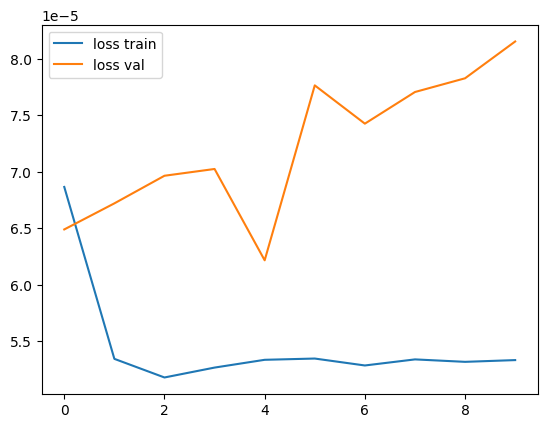

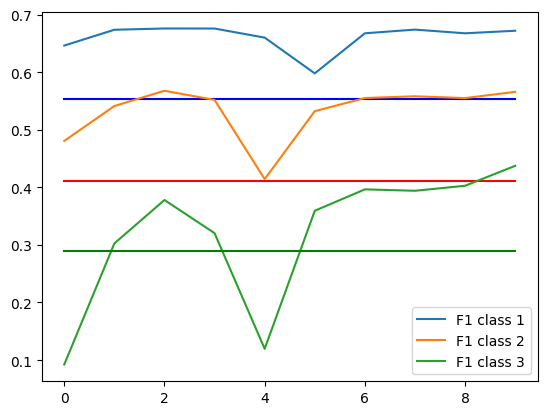

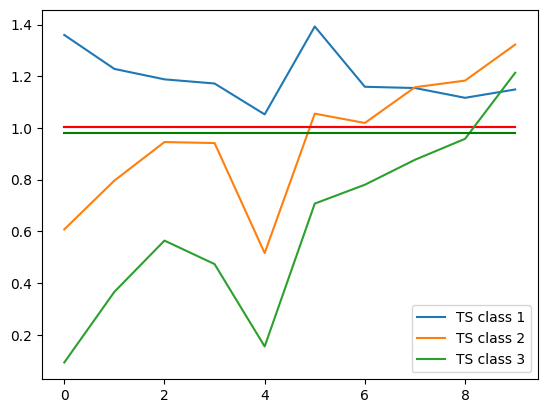

In [4]:
import matplotlib.pyplot as plt
def plot_scores( scores):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    sc = scores['val_bias']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='TS class 1')
    plt.plot([scores['bias_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='TS class 2')
    plt.plot([scores['bias_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='TS class 3')
    plt.plot([scores['bias_pers'][2]]*l,'g')
    plt.legend()
    plt.show()

plot_scores(scores_s2)

In [5]:
from models.FsrGAN_no_wind import FsrSecondStageGeneratorRadarOnly

thresholds = hyperpar_s2['thresholds']
input_len = 12
time_horizon = 6
stride = 12
batch_size = 16
model_g_s2 = FsrSecondStageGeneratorRadarOnly(input_len, time_horizon, size_factor=2, predict_sequence=True)

In [6]:
model_g_s2.load_state_dict(torch.load(f'{rundir_s2}/model_s2_last_epoch.pt'))

class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def __call__(self, x, x_s1):
        return train_ds.denormalize_rainmap(self.model(x, x_s1)).squeeze(1)
    def to(self, device):
        self.model.to(device)
        return self
    def eval(self):
        self.model.eval()
        return self
model_s2_g_wrapp = ModelWrapper(model_g_s2)

/tmp/ipykernel_177172/4144491516.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_g_s2.load_state_dict(torch.load(f'{rundir_s2}/model_s2_last_epoch.pt'))


In [7]:
from meteonet.loader import MeteonetDatasetChunked, DatsetWrapperFsrSecondStage
from meteonet.samplers import meteonet_sequential_sampler
from torch.utils.data import DataLoader
import os

test_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "test",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False,
    skip_withou_wind=True
)
test_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "test"), test_ds
)
val_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "val",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False,
    skip_withou_wind=True
)
val_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "val"), val_ds
)
train_ds = MeteonetDatasetChunked(
    "./data-chunked/",
    "train",
    input_len,
    input_len + time_horizon,
    stride,
    target_is_one_map=False,
    use_wind=False,
    normalize_target=False,
    skip_withou_wind=True
)
train_ds_wrapp = DatsetWrapperFsrSecondStage(
    os.path.join('cache/first_stage_predictions/', "train"), train_ds
)

test_sampler = meteonet_sequential_sampler(test_ds_wrapp)
test_loader = DataLoader(
    test_ds_wrapp,
    batch_size,
    sampler=test_sampler,
    num_workers=4,
    pin_memory=True,
)


Loading cached moments for test data from ./data-chunked/moments_test.npz
Loading cached moments for val data from ./data-chunked/moments_val.npz
Loading cached moments for train data from ./data-chunked/moments_train.npz


In [34]:
from meteonet.plots import plot_meteonet_rainmaps
from tests.pred_example.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

test_date = 2018, 2, 11, 14, 5
# plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)


import matplotlib.pyplot as plt
from matplotlib import colors
from meteonet.utilities import get_item_by_date, load_map, split_date, map_to_classes
import torch

def plot_inference(ds, date, model, thresholds, lon, lat, zone, title):
    """ plot an inference for a given date and compare to truth """
    idx = ds.dataset.get_item_idx_by_date(date)    
    if idx == None: return None

    item = ds[idx]
    model.eval()
    with torch.no_grad():
        preds = model(item['inputs'].unsqueeze(0), item['first_stage_pred'].unsqueeze(0)).squeeze(0)
    y, M, d, h, m = split_date(item['target_name'])

    fig, axes = plt.subplots(3, preds.shape[0], figsize=(20, 11))
    fig.suptitle(title) 

    cmap = colors.ListedColormap(['white', 'mediumblue', 'skyblue', 'cyan'])

    for i in range(preds.shape[0]):
        pred = 1 * (preds[i] > thresholds[0]) + (preds[i] > thresholds[1]) + (preds[i] > thresholds[2])
        pred = pred.squeeze()
        pred[0, 0] = 3
        target = item['target'][i]
        true = 1 * (target > thresholds[0]) + (target > thresholds[1]) + (target > thresholds[2])

        stage_1 = ds.dataset.denormalize_rainmap(item['first_stage_pred'][i])
        stage_1 = 1 * (stage_1 > thresholds[0]) + (stage_1 > thresholds[1]) + (stage_1 > thresholds[2])
        stage_1 = stage_1.squeeze()

        axes[0, i].set_title(f'Time step {i+1} Truth')
        axes[0, i].set_xlabel('longitude')
        axes[0, i].pcolormesh(lon, lat, true, cmap=cmap)
        
        axes[1, i].set_title(f'Time step {i+1} Prediction S2')
        axes[1, i].set_ylabel('latitude')
        axes[1, i].set_xlabel('longitude')
        axes[1, i].pcolormesh(lon, lat, pred, cmap=cmap)

        axes[2, i].set_title(f'Time step {i+1} Prediction S1')
        axes[2, i].set_ylabel('latitude')
        axes[2, i].set_xlabel('longitude')
        axes[2, i].pcolormesh(lon, lat, stage_1, cmap=cmap)

    plt.subplots_adjust(hspace=0.3)
    fig.text(0.3, -0.05, 'thresholds: mediumblue >= 0.8, skyblue >= 8.3, cyan >=20.3')
    plt.show()

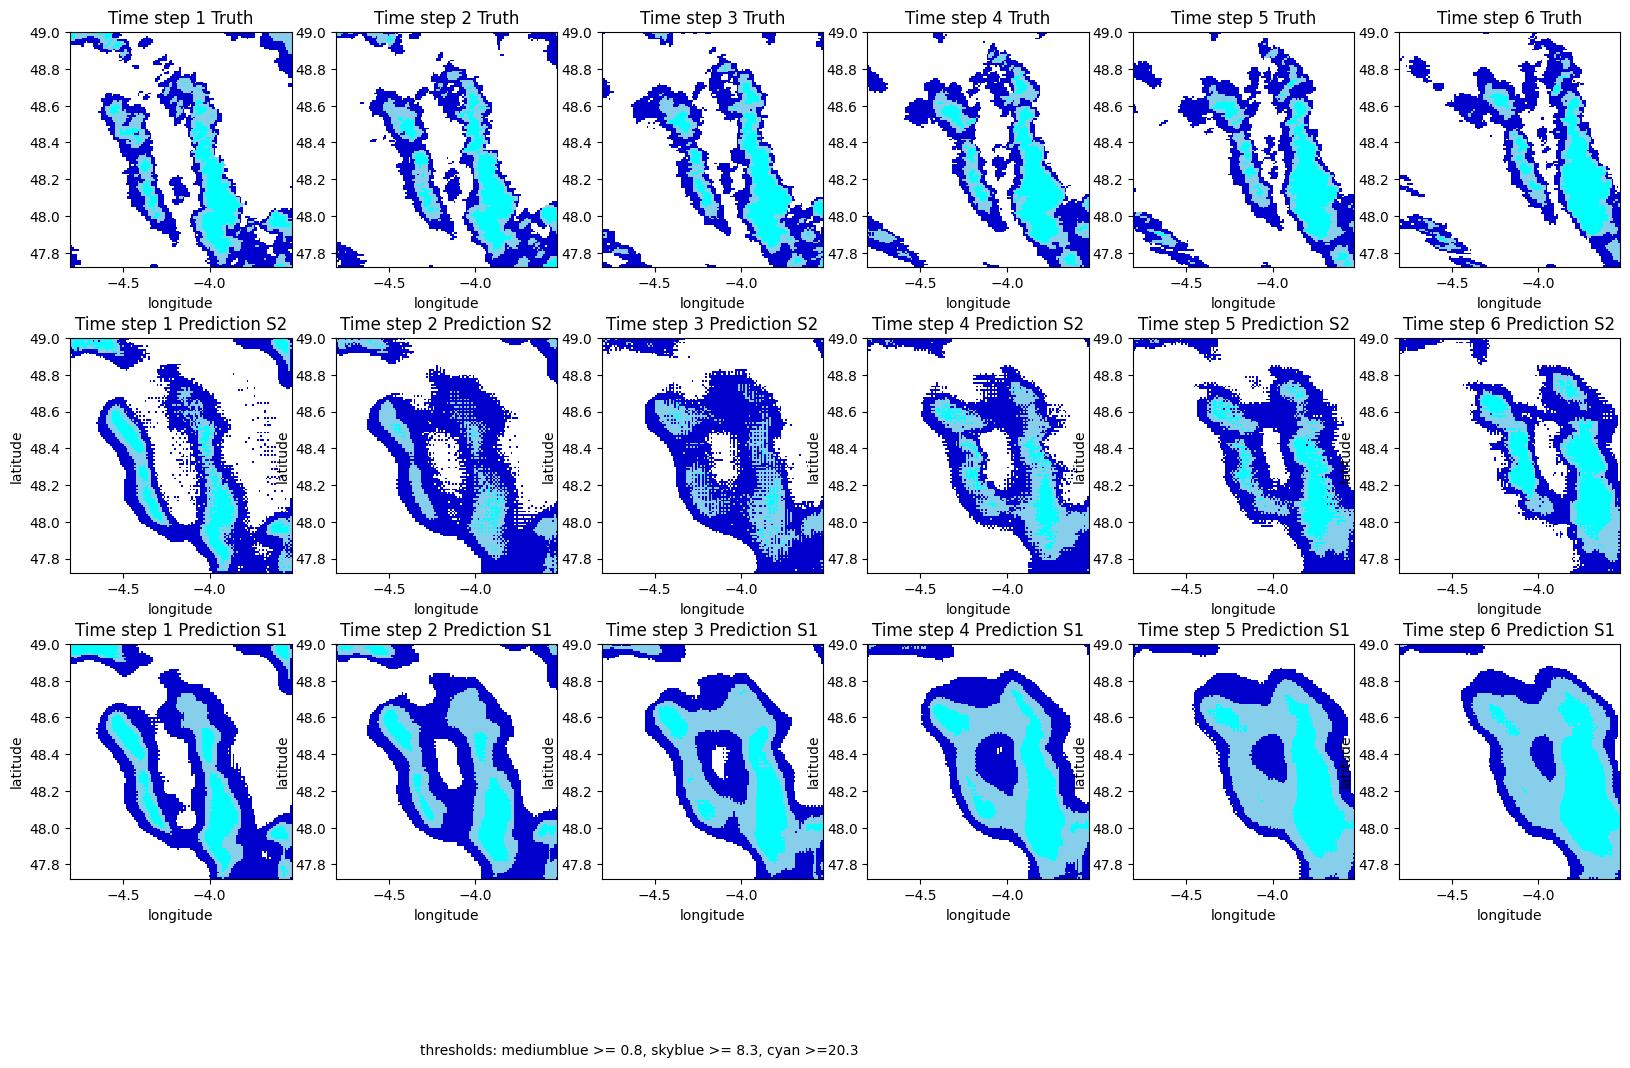

In [35]:
thresholds = hyperpar_s2['thresholds']

train_date = 2017,4,1,12,0 # dans train_ds
train_date = 2017,9,1,12,0 # dans train_ds
train_date = 2017,12,1,12,0 # dans train_ds
train_date = 2017,1,1,12,0 # dans train_ds
train_date = 2017,2,3,12,0 # dans train_ds
plot_inference( train_ds_wrapp, train_date, model_s2_g_wrapp.to('cpu'), thresholds, lon, lat, zone, '')

In [18]:
from tqdm import tqdm
from meteonet.utilities import calculate_CT, calculate_BS, map_to_classes
import pandas as pd

device = torch.device('cuda')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y,x_s1 = data['inputs'], train_ds.denormalize_rainmap(data['target'][:,-1]), data['first_stage_pred']
        x, y, x_s1 = x.to(device), y.to(device), x_s1.to(device)
        with torch.no_grad():
            y_hat = model(x, x_s1)[:,-1].squeeze(1)
        # print(y_hat.shape, y.shape)
        # print(y_hat.shape, y.shape)
        TPFPFN += calculate_CT(map_to_classes(y_hat, thresholds), map_to_classes(y, thresholds))
        # print(TPFPFN)
    return TPFPFN.cpu()

In [19]:
stats = eval_test( test_loader, model_s2_g_wrapp, device)

100%|██████████| 241/241 [00:14<00:00, 17.15it/s]


In [20]:
pd.DataFrame( stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,2729680,1494028,522728
TN,58317998,59219868,59385106
FP,1117513,215643,50405
FN,995129,2230781,3202081


In [21]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
scores_BS = ['Precision', 'Recall',              'F1','TS',    'BIAS','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_BS( stats, scores_BS), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.709525,0.873869,0.912054
Recall/Success Ratio,0.732838,0.401102,0.140337
F1,0.720993,0.549833,0.243246
TS/CSI,0.563713,0.379151,0.138463
Bias,1.032856,0.458996,0.153869
HSS,0.703207,0.532485,0.231152
FAR,0.018802,0.003628,0.000848
Accuracy,0.966551,0.961266,0.948504
ETS,0.542266,0.362848,0.130680
ORSS,0.986125,0.989185,0.989655


# Optuna visualization

In [1]:
opuna_file = 'optuna_runs/2/optuna_study.pkl'

# visualiza mapas de chuva
import optuna
import matplotlib.pyplot as plt
import pickle
import optuna.visualization as vis

with open(opuna_file, "rb") as f:
	study = pickle.load(f)

# Visualize study maps where axes are learning rate, value is score
fig = vis.plot_param_importances(study)
fig.show()

/home/ddrozdov/.venvs/MyEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualize the dependence between hyperparameters
fig = vis.plot_contour(study, params=['lr_g1', 'lr_g2', 'lr_d'])
fig.show()

In [1]:
import torch

def calculate_time_weights(T, device, alpha=1.6):
    time_weights = torch.tensor([alpha**t for t in range(T)], device=device)  # Shape: [T]
    time_weights = time_weights / time_weights.sum()  # Normalize time weights to sum to 1
    time_weights = time_weights.view(1, T, 1, 1)  # Shape: [1, T, 1, 1]
    return time_weights

calculate_time_weights(6, 'cpu')

tensor([[[[0.0380]],

         [[0.0608]],

         [[0.0974]],

         [[0.1558]],

         [[0.2492]],

         [[0.3988]]]])